In [1]:
import time
import math
import random
import pandas as pd
import numpy as np
import ggplot as gp

from collections import namedtuple

In [2]:
'''
struct to storage order price and volume to trade

Usage:
a = Order(price=1, volume=1)
'''

Order = namedtuple('order', 'id price volume')

In [3]:
class Dynamic_order:
    '''
    extension of Order, used in making deals
    '''
    def __init__(self, order):
        assert isinstance(order, Order)
        self.id = order.id
        self.price = order.price
        self.volume = order.volume
    @property
    def show(self):
        print('id : %d' % self.id)
        print('price : %d' % self.price)
        print('volume : %d' % self.volume)

In [4]:
class Basic_Trader:
    '''
    A primary class to define an investor, including actions
    like gennerate an order, and update it's own status with
    the trading result
    '''
    def __init__(self, id, asset, stock_price, *kw, **args):
        self.id = id
        self.asset = asset # 总资产
        self.stock_price = stock_price
        self.cash, self.stock = self.random_init(asset, stock_price)
        self.cash_history = [self.cash]
        self.asset_history = [self.asset]
        self.stock_history = [self.stock]
        self.trade_history = [] # 交易记录
        self.order = Order(id=self.id,
                           price=0,
                           volume=0)
        
    def random_init(self, asset, stock_price):
        stock_max = math.floor(asset/stock_price)
        stock_num = random.randint(0, stock_max)
        cash = asset - stock_num * stock_price
        return cash, stock_num
        
    def gen_order(self):
        self.order = Order(id=self.id,
                           price=np.random.randint(1, 20), 
                           volume=np.random.randint(-5, 5))
        
    def update(self, price, vol):
        self.cash -= price * vol
        self.cash_history.append(self.cash)
        self.stock += vol
        self.stock_history.append(self.stock)
        self.trade_history.append((price, vol))
        
        self.stock_price = price
        self.asset = self.cash + self.stock * self.stock_price
        self.asset_history.append(self.asset)
        
    @property
    def show(self):
        print('id : %d, cash : %d, stock : %d, stock_price : %d, asset : %d' % 
             (self.id, self.cash, self.stock, self.stock_price, self.asset))
        
    @property
    def show_detail(self):
        print('id : ', self.id)
        print('cash : ', self.cash)
        print('cash_history : ', self.cash_history)
        print('stock : ', self.stock)
        print('stock_history : ', self.stock_history)
        print('asset : ', self.asset)
        print('asset_history : ', self.asset_history)
        print('stock_price : ', self.stock_price)
        
    @property
    def show_asset(self):
        asset_table = pd.DataFrame({'time_step':range(len(self.asset_history)), 'asset':self.asset_history}, 
                           columns=['time_step', 'asset'])
        p = gp.ggplot(gp.aes(x='time_step', y='asset'), data = asset_table) + \
            gp.geom_line() + \
            gp.xlim(0, len(self.asset_history)) + \
            gp.ggtitle('Asset trend')
        print(p)

In [5]:
class Advanced_Trader(Basic_Trader):
    '''
    An example to extend the Basic_Trader class, this kind
    of traders have the chance of 60% to trade, the price 
    is given by previous stock price with a jitter, the sign
    of jitter indicates buying or selling, stock hold must be
    positive
    '''
    def gen_order(self):
        TRADE_PROB = 0.6
        trade_bool = random.random()
        if trade_bool < TRADE_PROB:
            eps = np.random.randn()
            price = np.max([self.stock_price + eps, 1])
            if eps > 0:
                vol_max = math.floor(self.cash / price)
                volume = np.random.randint(0, vol_max) if vol_max>0 else 0
            else:
                volume = np.random.randint(-self.stock, 0) if self.stock>0 else 0
        else:
            price = 0
            volume = 0
        self.order = Order(id=self.id,
                           price=price, 
                           volume=volume)

In [6]:
class Market:
    '''
    A class to define a market stucture, initialize with a 
    number of investors, have the ability to generate orders
    and deal with the orders from traders, returns a deal_price 
    and volume for every trader and update their status
    
    The history of price and volume is also contained, as well
    as indices like MA and so on
    '''
    def __init__(self, Trader_class, num_investors, asset, stock_price):
        self.investors = [Trader_class(i, asset=asset, stock_price=stock_price) for i in range(num_investors)]
        self.price = [stock_price]
        self.vol = []
        self.MA_5 = []
        self.MA_10 = []
        self.MA_100 = []
        self.MA_500 = []
        
    def make_deals(self, orders):
        buy_list = [Dynamic_order(order) for order in orders if order.volume>0]
        sell_list = [Dynamic_order(order) for order in orders if order.volume<0]

        buy_list = sorted(buy_list, key=lambda x:(-x.price, x.id))
        sell_list = sorted(sell_list, key=lambda x:(x.price, x.id))
        deal_result = np.zeros(len(orders), int)
        price = 0
        if len(buy_list)==0 or len(sell_list)==0:
            return price, deal_result
        while buy_list[0].price - sell_list[0].price >= 0:
            if sell_list[0].volume + buy_list[0].volume <= 0:
                sell_list[0].volume += buy_list[0].volume
                deal_result[buy_list[0].id] += buy_list[0].volume
                deal_result[sell_list[0].id] -= buy_list[0].volume
                if sell_list[0].volume + buy_list[0].volume == 0:
                    price = (buy_list[0].price + sell_list[0].price) / 2
                else:
                    price = sell_list[0].price
                _ = buy_list.pop(0)
            else:
                buy_list[0].volume += sell_list[0].volume
                deal_result[buy_list[0].id] -= sell_list[0].volume
                deal_result[sell_list[0].id] += sell_list[0].volume
                price = buy_list[0].price
                _ = sell_list.pop(0)           
            price = abs(price)
            if len(buy_list)==0 or len(sell_list)==0:
                break
        assert np.sum(deal_result)==0
        self.update(price, deal_result)
        return price, deal_result
    
    def update(self, price, deal_result):
        self.price.append(price)
        self.vol.append(np.sum(deal_result))
        duration = len(self.price)
        self.MA_5.append(np.mean(self.price[-5:]) if duration>5 else 0)
        self.MA_10.append(np.mean(self.price[-10:]) if duration>10 else 0)
        self.MA_100.append(np.mean(self.price[-100:]) if duration>100 else 0)
        self.MA_500.append(np.mean(self.price[-500:]) if duration>500 else 0)
        
    def step(self):
        orders = []
        for investor in self.investors:
            investor.gen_order()
            orders.append(investor.order)

        price, deal_result = self.make_deals(orders)
        for i,investor in enumerate(self.investors):
            investor.update(price=price, vol=deal_result[i])
            
    @property
    def show_price(self):
        price_table = pd.DataFrame({'time_step':range(len(self.price)), 'price':self.price}, 
                                   columns=['time_step', 'price'])
        p = gp.ggplot(gp.aes(x='time_step', y='price'), data = price_table) + \
            gp.geom_line() + \
            gp.xlim(0, len(self.price)) + \
            gp.ggtitle('Price trend')
        print(p)

In [7]:
market = Market(Advanced_Trader, 30, asset=1000, stock_price=10.0)
for i in range(30):
    market.step()

In [8]:
sum = 0
for investor in market.investors:
    investor.show
    sum += investor.asset
    
print('Total asset : ', sum)

id : 0, cash : 564, stock : 37, stock_price : 8, asset : 891
id : 1, cash : 641, stock : 2, stock_price : 8, asset : 659
id : 2, cash : 670, stock : 19, stock_price : 8, asset : 838
id : 3, cash : 857, stock : 28, stock_price : 8, asset : 1105
id : 4, cash : 253, stock : 74, stock_price : 8, asset : 907
id : 5, cash : 657, stock : 40, stock_price : 8, asset : 1010
id : 6, cash : 355, stock : 56, stock_price : 8, asset : 851
id : 7, cash : 83, stock : 117, stock_price : 8, asset : 1118
id : 8, cash : 1016, stock : 1, stock_price : 8, asset : 1024
id : 9, cash : 905, stock : 5, stock_price : 8, asset : 949
id : 10, cash : 949, stock : 0, stock_price : 8, asset : 949
id : 11, cash : 919, stock : 7, stock_price : 8, asset : 981
id : 12, cash : 127, stock : 102, stock_price : 8, asset : 1029
id : 13, cash : 54, stock : 84, stock_price : 8, asset : 797
id : 14, cash : 490, stock : 51, stock_price : 8, asset : 941
id : 15, cash : 937, stock : 1, stock_price : 8, asset : 946
id : 16, cash : 37

id :  0
cash :  564.493418323
cash_history :  [730.0, 896.75245952343005, 499.44176098392569, 262.61933304100637, 262.61933304100637, 181.611680195909, 181.611680195909, 181.611680195909, 112.27485735306041, 112.27485735306041, 82.236926222089352, 91.956713777433407, 74.61292267590315, 74.61292267590315, 74.61292267590315, 33.307173786019419, 33.307173786019419, 33.307173786019419, 33.307173786019419, 207.15554447860944, 404.20904613445168, 404.20904613445168, 884.08932670263232, 903.3300979925458, 903.3300979925458, 903.3300979925458, 55.229424556469098, 539.91848724473664, 539.91848724473664, 564.4934183230888, 564.4934183230888]
stock :  37
stock_history :  [27, 14, 48, 69, 69, 76, 76, 76, 82, 82, 85, 84, 86, 86, 86, 90, 90, 90, 90, 72, 51, 51, 3, 1, 1, 1, 107, 40, 40, 37, 37]
asset :  891.731252056
asset_history :  [1000, 1076.3320313178931, 1060.3509824514613, 1040.7501677105984, 1100.1410832237857, 1061.1233396569664, 1055.4039694173557, 1098.1172526538335, 1059.8781028719911, 10

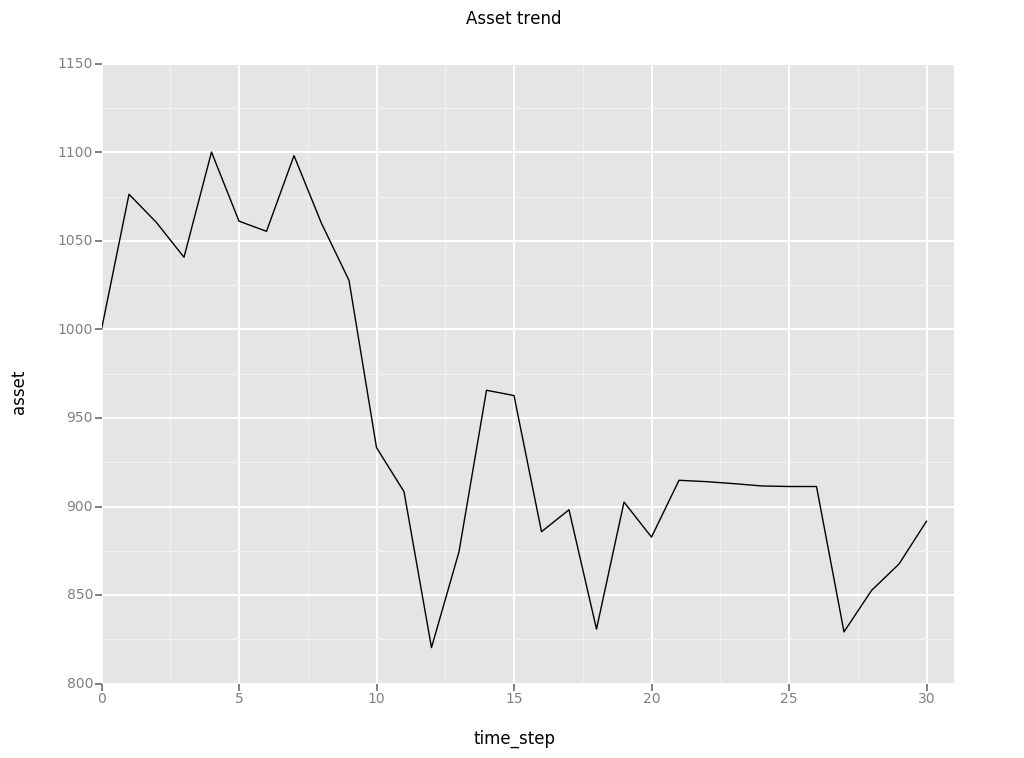

<ggplot: (8755219643256)>


In [9]:
market.investors[0].show_detail
market.investors[0].show_asset

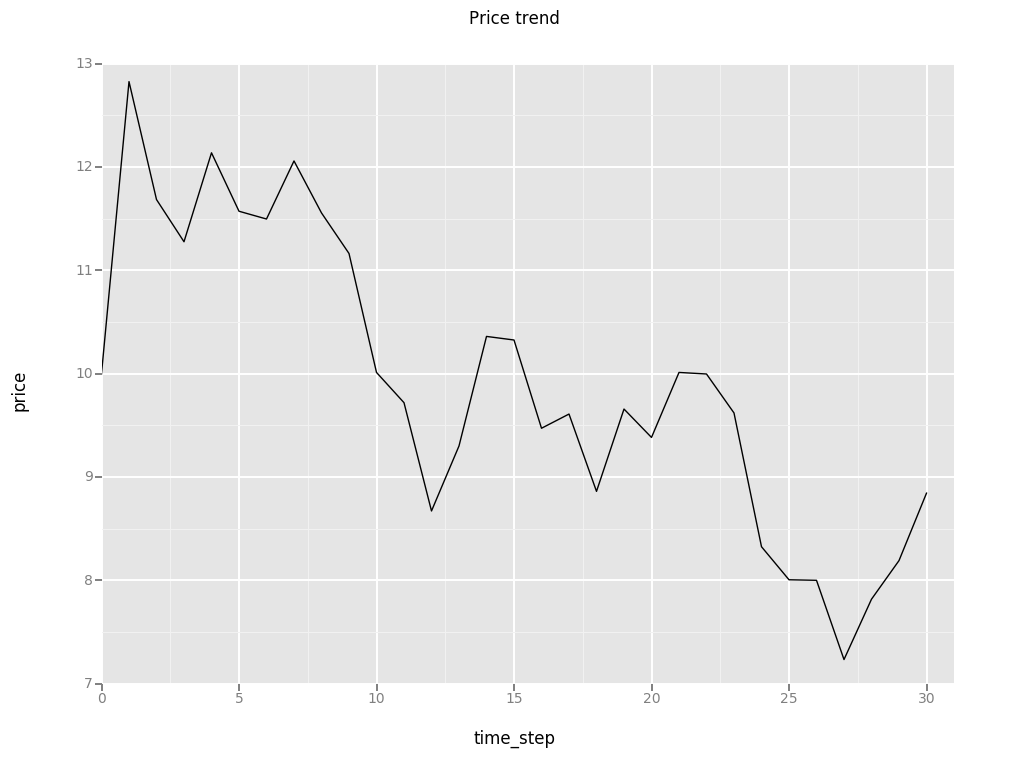

<ggplot: (8755219637459)>


In [10]:
market.show_price